# Проект

In [ ]:
%pip install kagglehub pandas matplotlib tqdm nltk torch numpy transformers

In [ ]:
from tqdm import tqdm
import re

import random
import os
import numpy as np

import torch

import kagglehub
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
tqdm.pandas()

In [ ]:
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

## Датасет

Скачаем наш датасет и проанализируем его

In [ ]:
%%time
ds_path = kagglehub.dataset_download("kamaruladha/mental-disorders-identification-reddit-nlp")
ds_path

In [ ]:
dataset = pd.read_csv(f'{ds_path}/mental_disorders_reddit.csv')
dataset.head()

Рассмотри его подробнее. В качестве класса выступает поле `subreddit`, идентифицирующее ментальное заболевание. Посмотрим на его распределение в рамках датасета

In [ ]:
dataset.rename(columns={'subreddit': 'class'}, inplace=True)

In [ ]:
def show_dataset_info():
    class_counts = dataset['class'].value_counts()
    print(class_counts)

    plt.figure(figsize=(8, 6))
    plt.pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%')
    plt.title('Распределение классов')

In [ ]:
show_dataset_info()

### Предобработка

В описании датасета сказано:

> The dataset is field with "troll" posts that would only disturb the learning process of the model. The troll post may look something like this ("I AM IN YOUR WALLS/FLOORBOARD/CEILING/etc). The purpose of these troll posts are still unknown. Thus, heavy preprocessing is needed to ensure that the model is only fed with high quality data.

Поэтому займемся его предобработкой. Помимо удаления "троллинговых" постов, стоит еще заняться очисткой коротких текстов, чтобы наши модели могли качественно обучиться.

In [ ]:
# Очищает удаленные записи в датасете. Такие посты помечены как [removed]
clean_removed_mask = dataset.apply(lambda row: row['selftext'] != '[removed]' and row['title'] != '[removed]', axis=1)
dataset = dataset[clean_removed_mask]
dataset = dataset.dropna()

In [ ]:
# Удаляем лишний класс
dataset = dataset[dataset['class'] != 'mentalillness']

In [ ]:
dataset = dataset[dataset.apply(lambda row: 'I AM IN YOUR WALLS' not in row['selftext'], axis=1)]

In [ ]:
# Удаляем короткие посты.
dataset = dataset[dataset.apply(lambda row: len(row['selftext']) > 150, axis=1)]

Для дальнейшего упрощения обучения моделей "смержим" два столбца (`title` и `selftext`) в один. Заодно удалим лишние столбцы.

In [ ]:
dataset['text'] = dataset['title'] + ' ' + dataset['selftext']
dataset.drop(['selftext', 'title', 'created_utc', 'over_18'], axis=1, inplace=True)

In [ ]:
dataset.head()

В датасете также встречаются слова с сокращениями (`I've`, `gotta`, `can't`, etc.). По-хорошему их тоже следует очистить

In [ ]:
abbr_dict = {
    "'cause": "because",
    "ain't": "am not",
    "can't": "can not",
    "cannot": "can not",
    "could've": "could have",
    "couldn't": "could not",
    "didn't": "did not",
    "doesnt": "does not",
    "dont": "do not",
    "gimme": "give me",
    "gotta": "got to",
    "hadn't": "had not",
    "hadnt": "had not",
    "hasn't": "has not",
    "hasnt": "has not",
    "haven't": "have not",
    "havent": "have not",
    "he'd": "he would",
    "he'll": "he will",
    "he's": "he is",
    "here's": "here is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'm": "i am",
    "i'll": "i will",
    "i've": "i have",
    "i ve": "i have",
    "imma": "i am going to",
    "isn't": "is not",
    "it'll": "it will",
    "it's": "it is",
    "lemme": "let me",
    "let's": "let us",
    "not've": "not have",
    "shouldn't": "should not",
    "she'll": "she will",
    "she's": "she is",
    "that's": "that is",
    "there's": "there is",
    "there're": "there are",
    "they'd": "they would",
    "they'll": "they will",
    "they're": "they are",
    "they've": "they have",
    "wasn't": "was not",
    "wasnt": "was not",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "werent": "were not",
    "what's": "what is",
    "what're": "what are",
    "when's": "when is",
    "when're": "when are",
    "where's": "where is",
    "where're": "where are",
    "who's": "who is",
    "who're": "who are",
    "who've": "who have",
    "won't": "will not",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
}

In [ ]:
def replace_abbreviations(text):
    # Заменим "don't" на "do not"
    text = re.sub(r'\bdon t\b', 'do not', text, flags=re.IGNORECASE)
    # Заменим "i ve" на "i have"
    text = re.sub(r'\bi ve\b', 'i have', text, flags=re.IGNORECASE)

    # Заменим аббревиатуры
    for word in text.split():
        if word.lower() in abbr_dict:
            text = re.sub(r'\b{}\b'.format(word), abbr_dict[word.lower()], text, flags=re.IGNORECASE)

    return text

In [ ]:
dataset['text'] = dataset['text'].progress_apply(replace_abbreviations)

В датасете также встечались эмодзи, их тоже следует удалить

In [ ]:
dataset['text'] = dataset['text'].apply(lambda x: str(x).encode('ascii', 'ignore').decode('ascii'))

Посмотрим теперь вновь на сбалансированность нашего датасета.

class
BPD              193717
Anxiety          147897
depression       107003
bipolar           30741
schizophrenia      9443
Name: count, dtype: int64


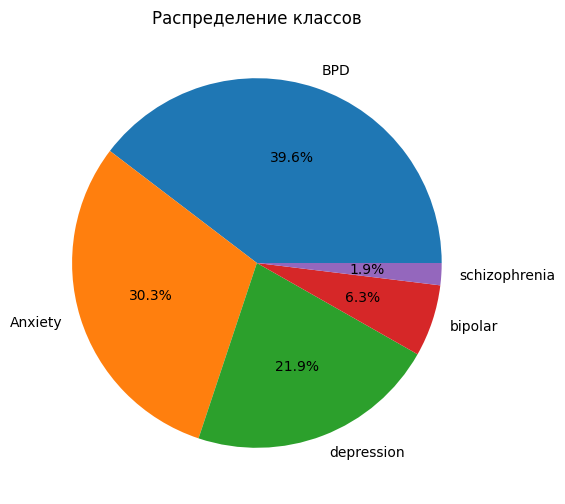

In [65]:
show_dataset_info()

Видно, что данных по шизофрении и биполярке мало. Их можно разбавить, сгенерировав похожие по смыслу данные. Заодно обрезать размер нашего датасета до 30 000 записей на каждый класс — такого объема точно хватит для качественного
результата, а также мы сократим время, требуемое на обучение моделей и генерацию аугментаций.

In [80]:
dataset = dataset.groupby('class', group_keys=False).apply(lambda x: x.sample(n=min(len(x), 30000), random_state=42), include_groups=True).reset_index(drop=True)

/var/folders/3y/jpw0zmz931vf555w9z3n5pwr0000gn/T/ipykernel_99184/4202718560.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dataset = dataset.groupby('class', group_keys=False).apply(lambda x: x.sample(n=min(len(x), 30000), random_state=42), include_groups=True).reset_index(drop=True)


In [ ]:
%pip install nlpaug wordnet

In [ ]:
import nlpaug.augmenter.word as naw
import nlpaug.flow as naf

In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('punkt')

In [ ]:
aug_flow = naf.Sequential([
    naw.ContextualWordEmbsAug(
        model_path="google-bert/bert-base-cased",
        aug_p=0.2,
    ),
    naw.SynonymAug(aug_src='wordnet', aug_p=0.3, aug_max=10)
])

In [ ]:
example_text_to_change = dataset['text'].sample(1, ignore_index=True)[0]
augmented_text = aug_cwe.augment(
    example_text_to_change,
)[-1]
print('BEFORE:', example_text_to_change)
print('')
print('AFTER:', augmented_text)

class
BPD              193717
Anxiety          147897
depression       107003
bipolar           30741
schizophrenia      9443
Name: count, dtype: int64


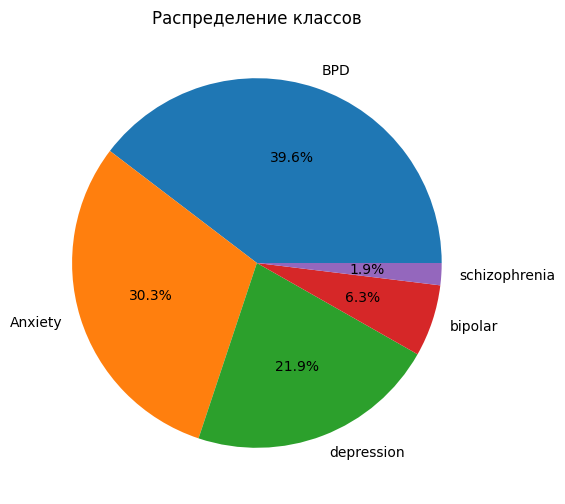

In [60]:
show_dataset_info()

In [82]:
def generate_text_augmentations(target_class='schizophrenia'):
    assert target_class in ['schizophrenia']

    class_texts = dataset[dataset['class'] == target_class]['text'].dropna().tolist()
    target_n = 100_000
    augmented_texts = class_texts

    with tqdm(total=target_n - len(augmented_texts)) as pbar:
        while len(augmented_texts) < target_n:
            chosen_text = random.choice(class_texts)

            new_augments = aug_flow.augment(chosen_text, n=min(100, target_n - len(augmented_texts)))
            valid_augments = []
            for aug in new_augments:
                valid_augments.append(aug)

            augmented_texts.extend(valid_augments)
            pbar.update(len(new_augments))

    return augmented_texts[:target_n]

In [64]:
%%time
generate_text_augmentations()

  0%|          | 300/69259 [02:06<8:02:48,  2.38it/s]


KeyboardInterrupt: 

In [ ]:
%%time
generate_text_augmentations('bipolar')